# Time-Varying and Time-Aggregate Sensitivity Analysis

Notebook developed by Saman Razavi and Kasra Keshavarz

### For the VARS method on dynamical model response, please cite:

Razavi, S., & Gupta, H. V. (2019). A multi-method Generalized Global Sensitivity Matrix approach to accounting for the dynamical nature of earth and environmental systems models. Environmental modelling & software, 114, 1-11. https://doi.org/10.1016/j.envsoft.2018.12.002

### For HBV-SASK, please cite:

Razavi, S., Sheikholeslami, R., Gupta, H. V., & Haghnegahdar, A. (2019). VARS-TOOL: A toolbox for comprehensive, efficient, and robust sensitivity and uncertainty analysis. Environmental modelling & software, 112, 95-107. https://www.sciencedirect.com/science/article/pii/S1364815218304766

# Exercise 7: Sensitivity Analysis of HBV-SASK dynamical outputs
### Objective:

This notebook accounts for the dynamical nature of the HBV-SASK model in sensitivity analysis using the Generalized Global Sensitivity Matrix (GGSM) approach implemented via STAR-VARS.

First import the needed librares, including `TVARS` for time-varying sensitivity analysis and the `Model` class for creating a wrapper around the desired model so that it can be inputted into VARS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from varstool import TSVARS, Model
import hbv

### Introduce the model

Define the function of interest in sensitivity analysis. Here, the following function runs the HBV-SASK model and returns a **time series of model responses**. The output of the model here could be the time series of a flux (e.g., *streamflow*) or state variable (e.g., *soil moisture*) over a given time period. 

In [2]:
def custom_HBV_SASK_2(x):
    # preparing the inputs 
    x.index = ['TT', 'C0', 'ETF', 'LP', 'FC', 'beta', 'FRAC', 'K1', 'alpha', 'K2', 'UBAS', 'PM']
    param = x.to_dict()
    
    # running the HBV-SASK Model
    basin = 'Oldman Basin'  # choose the basin of interest, either 'Oldman Basin' or 'Banff Basin'
    flux, state, forcing = hbv.HBV_SASK(basin, param)
    
    start_day ='2005-10-01'  # choose the start date for the period of interest
    end_day   ='2006-09-30'  # choose the end date for the period of interest
    
    # choosing the flux or state variable of interest to report
    out = flux['Q_cms'][start_day:end_day]  # 'Q_cms' (streamflow) is an example flux
#     out = state['SMS'][start_day:end_day]   # 'SMS' (soil moisture storage) is an example state variable

    return out

Wrap the function of interest with the `Model` class.

In [3]:
HBV_model = Model(custom_HBV_SASK_2)

Let's run the wrapped function for an arbitrary input and check the model response.

In [4]:
x=pd.Series({#name  #value
             'TT'   : 0.0 ,
             'C0'   : 1.0 ,
             'ETF'  : 0.1 ,
             'LP'   : 0.3 ,
             'FC'   : 250 ,
             'beta' : 2.0 ,
             'FRAC' : 0.7 ,
             'K1'   : 0.05,
             'alpha': 1.5 ,
             'K2'   : 0.01,
             'UBAS' : 1.0 ,
             'PM'   : 1.0 ,
             })
HBV_model(x)

2005-10-01    19.519681
2005-10-02    24.286513
2005-10-03    21.284241
2005-10-04    18.467783
2005-10-05    16.315388
                ...    
2006-09-26     3.746911
2006-09-27     3.744465
2006-09-28     3.688073
2006-09-29     3.631065
2006-09-30     3.576262
Name: Q_cms, Length: 365, dtype: float64

### Set up a Time-varying VARS experiment

Create a TSVARS experiment and set its attributes, according to the table below. Note that VARS and TSVARS share the same attributes.
***

<p><center>Table 1. The attributes of the STAR-VARS algorithm </center></p>

| Attribute      | Description |
| :-------------:|:----------- |
|`paramaters`    | The name of every paramter along with its upper and lower bounds           |
|`num_stars`     | The total number of stars centers for VARS analysis                        |
|`delta_h`       | The sampling resolution of the STAR-VARS sampling to generate star points  |
|`ivars_scales`  | The scales of interest for IVARS estimation, e.g, 0.1 and 0.5 correspond (0-0.1) and (0-0.5) <br /> note: can not have a scale larger than 0.5|
|`star_centres`  | User-generated star centers - only used when a sampler is not chosen       |
|`sampler`       | The sampling strategy: `rnd`, `lhs`, `plhs`, `sobol_seq`, or `halton_seq` for generation of star centers|
|`seed`          | The seed number for randomization of the sampling strategy specified by `sampler`, <br /> only needed if a sampler was chosen  |
|`model`         | The wrapper of your model in the `Model` class|
|`bootstrap_flag`| This is a `True`/`False` value to turn on/off bootstrapping of VARS results   |
|`bootstrap_size`| The number of sampling iterations with replacement via bootstrapping |
|`bootstrap_ci`  | The level of confidence used in bootstrap reporting         |
|`grouping_flag` | This is a `True`/`False` value to turn on/off grouping of VARS results   |
|`num_grps`      | The number of groups you want to split your model paramaters into, <br /> if left blank the optimal number of groups will be calculated by VARS|
|`report_verbose`| this is a `True`/`False` value that if `True` will display a loading bar <br /> to show the progession of the VARS analysis, else there will be no progression loading bar|


In [5]:
experiment_2 = TSVARS(parameters = { # name   lower bound   upper bound
                                      'TT'   :  [ -4.00   ,   4.00],
                                      'C0'   :  [  0.00   ,   10.0],
                                      'ETF'  :  [  0.00   ,   1.00],
                                      'LP'   :  [  0.00   ,   1.00],
                                      'FC'   :  [  50.0   ,   500 ],
                                      'beta' :  [  1.00   ,   3.00],
                                      'FRAC' :  [  0.10   ,   0.90],
                                      'K1'   :  [  0.05   ,   1.00],
                                      'alpha':  [  1.00   ,   3.00],
                                      'K2'   :  [  0.00   ,   0.05],
                                      'UBAS' :  [  1.00   ,   3.00],
                                      'PM'   :  [  0.50   ,   2.00],},
                      num_stars        = 10,
                      delta_h          = 0.1,
                      ivars_scales     = (0.1, 0.3, 0.5),
                      sampler          = 'lhs',
                      seed             = 123456789,
                      model            = HBV_model,
                      bootstrap_flag   = False,
                      bootstrap_size   = 1000,
                      bootstrap_ci     = 0.9,
                      grouping_flag    = False,
                      num_grps         = 2,
                      report_verbose   = True,                   
                      func_eval_method ='serial', # The parallel version needs further development and testing
                      vars_eval_method ='serial', # The parallel version needs further development and testing
                      vars_chunk_size=None,
                     )

### Run STAR-VARS

Now, run the TSVARS experiment set up above.

In [ ]:
experiment_2.run_online()

function evaluation:   0%|                                                                    | 0/1200 [00:00<…

### Check out the results

When the TSVARS analysis is completed, let's check out the results of **time-varying** and **time-aggregate** sensitivity analysis.

**Time-Varying Sensitivities** 

Similar to `VARS`, `TSVARS` generates all the sensitivity indices, including IVARS, VARS-TO (Sobol Total-Order Effect), VARS-ABE and VARS-ACE (Morris Elementary Effect). But unlike `VARS` that generates sensitivity indices for a single model output, `TSVARS` does so for the time series of model outputs.

The following cells look at IVARS-50 (Total-Variogram Effect) only, but the user has the option to use other indices as already shown for `VARS`.
***
For IVARS-50, the result will be a table where each row represents a modelling time step and each column represents a model parameter. This table is called the *Generalized Global Sensitivity Matrix (GGSM)*.

In [7]:
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_2.parameters.keys()
time_varying_SA = experiment_2.ivars.loc[pd.IndexSlice[:, :, ivars_scale]].unstack(level=-1)[cols]
time_varying_SA

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
ts,,,,,,,,,,,,
2005-10-01,18.056459,7.236780,13.755770,12.251076,59.149743,2.192719,111.155415,8.805109,23.659054,2.315725,13.760011,393.956044
2005-10-02,174.858058,7.804141,17.022589,15.137740,70.025974,2.253249,146.337362,4.185601,13.356349,2.778403,0.794398,460.167464
2005-10-03,45.166507,5.142503,9.854175,8.250976,26.417313,1.245912,34.925697,1.426924,5.835488,2.567982,77.881077,201.336477
2005-10-04,188.876656,2.580460,4.322362,5.255970,11.864159,0.840518,10.975549,1.553829,2.585939,2.399937,16.125150,106.945324
2005-10-05,102.239926,1.940225,4.260390,5.148026,13.143351,0.810007,15.777662,1.609106,1.682997,2.249208,5.159518,115.221003
...,...,...,...,...,...,...,...,...,...,...,...,...
2006-09-26,0.258334,0.038359,0.151068,0.169328,0.234025,0.185538,2.282434,0.068322,0.020966,3.160770,0.002548,2.157854
2006-09-27,0.357068,0.037068,0.326995,0.303195,2.953882,0.946693,0.595977,0.707432,0.147765,3.095397,0.724549,6.504255
2006-09-28,0.325507,0.035716,0.229485,0.314119,0.535925,0.260302,1.884858,0.045443,0.015760,3.125677,0.559089,2.748072


Let's plot the time series above for a few select parameters.

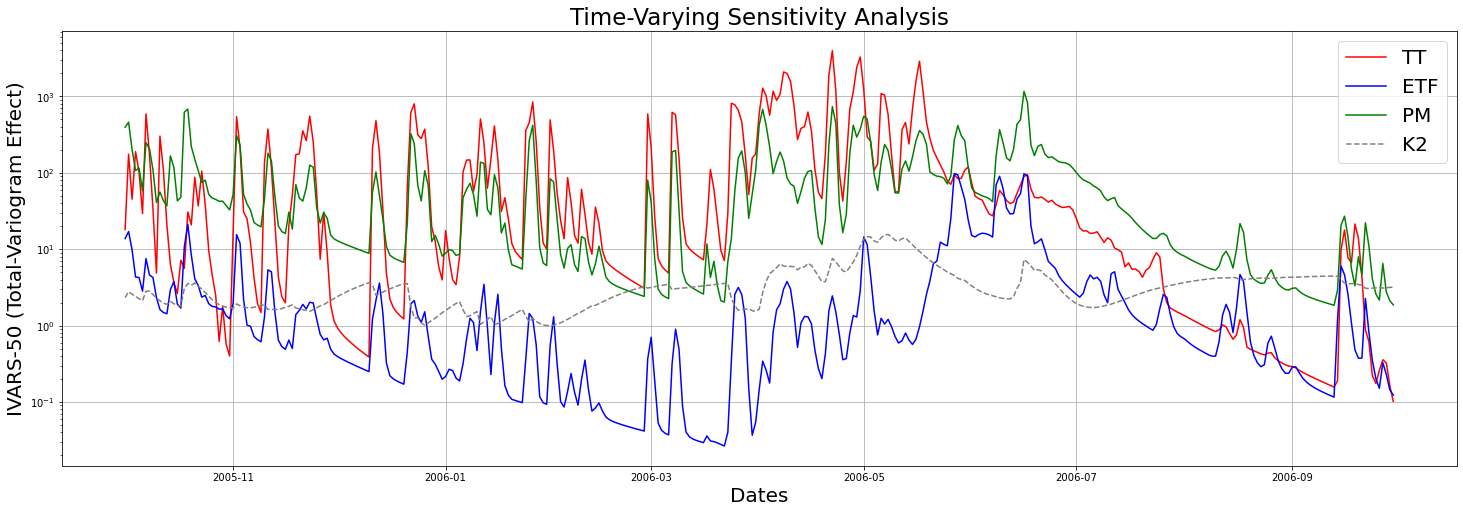

In [8]:
fig = plt.figure(figsize=(25, 8))

plt.gca().plot( time_varying_SA[ 'TT'  ] , '-'  , color='red'   , label=r'TT'  )
plt.gca().plot( time_varying_SA[ 'ETF' ] , '-'  , color='blue'  , label=r'ETF' )
plt.gca().plot( time_varying_SA[ 'PM'  ] , '-'  , color='green' , label=r'PM'  )
plt.gca().plot( time_varying_SA[ 'K2'  ] , '--' , color='grey'  , label=r'K2'  )

plt.gca().set_title(r'Time-Varying Sensitivity Analysis', fontsize = 23)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 20)
plt.gca().set_xlabel('Dates', fontsize=20)
plt.gca().grid()
plt.gca().legend(loc='upper right', fontsize = 20)
plt.gca().set_yscale('log')

**Time-Aggregate Sensitivities** 

The first level of time aggregation in the GGSM approach is through cumulative frequency distributions of the time series of sensitivity index for each individual parameter. The distributions that are more extended to the right correspond to parameters that are more strongly influential.

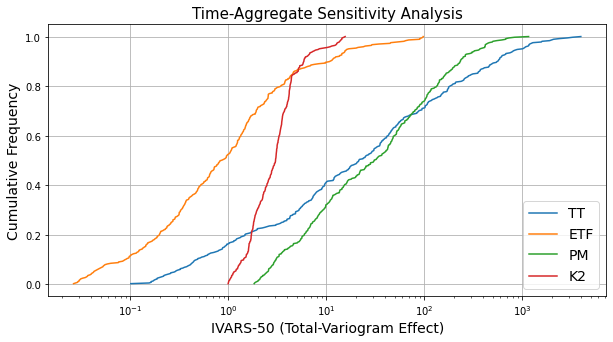

In [9]:
# choose the model parameters of interest for plotting the results
cols = ['TT', 'ETF', 'PM', 'K2']         # choose parameters for plotting
# cols = experiment_2.parameters.keys()  # or plot the results for all parameters

ivars_scale = 0.5                        # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

idx = pd.IndexSlice
time_varying_SA = experiment_2.ivars.loc[idx[:, :, ivars_scale]].unstack(level=-1)[cols]
matrix_x = np.sort(time_varying_SA.values, axis=0)  
column_y = np.linspace( 1, len(matrix_x), len(matrix_x))/len(matrix_x)
matrix_y = np.tile(column_y, (matrix_x.shape[1], 1)).T

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )

plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis', fontsize = 15)
plt.gca().set_ylabel(r'Cumulative Frequency', fontsize = 14)
plt.gca().set_xlabel(r'IVARS-50 (Total-Variogram Effect)', fontsize=14)
plt.gca().legend (cols, loc='lower right', fontsize = 14)
plt.gca().set_xscale('log')
plt.gca().grid()

The second level of aggregation (the most compact form) in the GGSM approach takes the *mean* of the time series of sensitivity index over the simulation time period for each individual parameter. The table below shows the time-aggregate IVARS for all the scale ranges of interest.

In [10]:
cols = experiment_2.parameters.keys()
time_aggregate_SA = experiment_2.ivars.aggregate.unstack(level=0)[cols]
time_aggregate_SA

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
h,,,,,,,,,,,,
0.1,7.669117,1.873904,0.058747,0.023351,0.113662,0.010691,0.307981,0.068699,0.134280,0.089123,0.152584,1.150610
0.3,71.352490,16.929979,1.075993,0.429241,1.504597,0.181967,5.820814,0.761060,1.773412,0.989054,2.901705,20.218901
0.5,183.071816,46.517760,4.649977,1.810388,5.375722,0.751965,25.956558,2.266883,5.236411,3.524508,12.472005,85.461478


Lastly, choose a scale range and plot the respective time-aggregate sensitivity indices for all the parameters in linear and log scales.

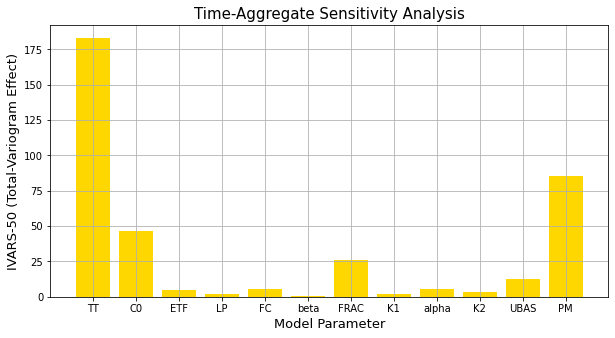

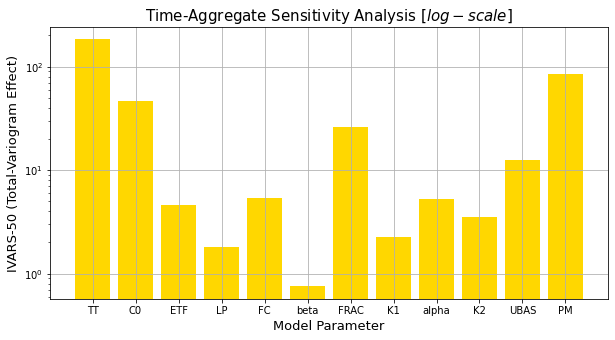

In [11]:
ivars_scale = 0.5   # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_2.parameters.keys()
time_aggregate_SA = experiment_2.ivars.aggregate.unstack(level=0)[cols]

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols,time_aggregate_SA.loc[pd.IndexSlice[ ivars_scale ]], color='gold')
plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().set_yscale('linear')
plt.gca().grid()

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols,time_aggregate_SA.loc[pd.IndexSlice[ ivars_scale ]], color='gold')
plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().set_yscale('log')
plt.gca().grid()

Well done!